In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/groceries-dataset-for-market-basket-analysismba/Groceries data.csv
/kaggle/input/groceries-dataset-for-market-basket-analysismba/basket.csv
/kaggle/input/quantium-data-analytics-virtual-experience-program/PurchaseBehaviour.csv
/kaggle/input/quantium-data-analytics-virtual-experience-program/Transactions.csv


# 1. Introduction
## 1.1 Summary
A market basket analysis would help understand the purchase behavior of customers. In a shopping cart, normally, there are several items as a combination depending on the preference of different customers. Knowing what items would come after particular items, shelf planners would have better ideas of what items should be put together. Also, retail managers would better understand what sorts of items should be stored in the warehouse to prevent insufficiency.

## 1.2 Analytics Tool and Dataset
This analysis uses Python as an analytics tool. 

There 2 given datasets. One contains 38765 transaction records with member IDs, transaction dates, and item names. The other one contains 14963 rows with only the items per transaction. 

# 2. Prepare
## 2.1 Analysis Plan
The analysis plan is to answer the questions.

1. What are the most frequently sold items?
2. what are the consequents of the chosen items?
3. How confident do the consequents come after the items?
4. What are the most important items that should always be in the store?
5. How the item network looks like?
6. What is the difference between analyzing the data based on customer ID and different transactions?


In [2]:
! pip install squarify
! pip install --index-url https://test.pypi.org/simple/ PyARMViz

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.6 MB/s eta 0:00:00


In [3]:
import numpy as np 
import pandas as pd 
from itertools import permutations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import igraph as ig
from plotly.graph_objs import *

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
df = pd.read_csv("../input/groceries-dataset-for-market-basket-analysismba/Groceries data.csv")
bk = pd.read_csv("../input/groceries-dataset-for-market-basket-analysismba/basket.csv")
df

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4
...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6
38761,2022,2014-02-23,candy,2014,2,23,6
38762,1097,2014-04-16,cake bar,2014,4,16,2
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2


In [5]:
# review the unique values in the member ID and item columns
print(len(df['Member_number'].unique()))
print(len(df['itemDescription'].unique()))

3898
167


In [6]:
# review the value counts
freq_items = df['itemDescription'].value_counts()
freq_items.head(10)

whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

In [7]:
#plot a bar chart to see the top sold items
fig = px.bar(data_frame=freq_items.head(40), title='Top 40 Items', color=freq_items.head(40),
                 labels={
                     "index": "Items",
                     "values": "Quantity",
                     'lift': 'Lift'
                 })
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

In [8]:
# list items by member IDs
user_id = df['Member_number'].unique()
items = [list(df.loc[df['Member_number'] == id, 'itemDescription']) for id in user_id]
print(items[0])

['tropical fruit', 'long life bakery product', 'meat', 'sugar', 'rolls/buns', 'semi-finished bread', 'whole milk', 'citrus fruit', 'candy', 'napkins']


In [9]:
# create a item matrix
TE = TransactionEncoder()
TE.fit(items)
item_transformed = TE.transform(items)
item_matrix = pd.DataFrame(item_transformed, columns = TE.columns_)
item_matrix.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


In [10]:
# get the support value by Apriori algorithm
freq_items = apriori(item_matrix, min_support=0.01, use_colnames=True, max_len=2)
freq_items.sort_values(by = "support", ascending = False)

,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
...,...,...
414,0.010005,"(frankfurter, butter milk)"
705,0.010005,"(dog food, whole milk)"
882,0.010005,"(hygiene articles, newspapers)"
1106,0.010005,"(pork, waffles)"


In [11]:
import squarify
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict


In [12]:
b = association_rules(freq_items, metric="lift", min_threshold=0.001)
b['uni'] = np.nan
b['ant'] = np.nan
b['con'] = np.nan
b['tot'] = 14963

In [13]:
transactions = [a[1]['itemDescription'].tolist() for a in list(df.groupby(['Member_number','Date']))]

def trans():
    for t in transactions:
        yield t
    
def ant(x):
    cnt = 0
    for t in trans():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1 
    return cnt

bb = b.values.tolist()  

In [14]:
rules_dict = []
for bbb in bb:
    bbb[10] = ant(bbb[0])
    bbb[11] = ant(bbb[1])
    bbb[9] = ant(bbb[0].union(bbb[1]))
    diction = {
        'lhs': tuple(bbb[0]), 
        'rhs': tuple(bbb[1]),
        'count_full': bbb[9],
        'count_lhs': bbb[10],
        'count_rhs': bbb[11],
        'num_transactions': bbb[12]
    }
    rules_dict.append(diction)

In [15]:
rules = []
for rd in rules_dict: 
    rules.append(generate_rule_from_dict(rd))

Parallel categories diagram is a visualization of multi-dimensional categorical datasets wherein each variable in the dataset is represented by a column of rectangles, where each rectangle corresponds to a discrete value taken on by that variable

Affinity Analysis: By looking for combinations of items that occur together frequently in transactions, we try to uncover associations between these items, for improving product placements for offline shopping. The graph shown outlines these associations visualized as rules.

In [16]:
#Parallel Category Plot
PyARMViz.generate_parallel_category_plot(rules)

In [17]:
# create a datafram with product support, confidence , and lift values
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,0.001133,1.016672
1,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396
2,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933
3,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477
...,...,...,...,...,...,...,...,...,...
2247,(whole milk),(white wine),0.458184,0.044125,0.023602,0.051512,1.167400,0.003384,1.007788
2248,(yogurt),(white wine),0.282966,0.044125,0.016419,0.058024,1.314976,0.003933,1.014754
2249,(white wine),(yogurt),0.044125,0.282966,0.016419,0.372093,1.314976,0.003933,1.141944
2250,(yogurt),(whole milk),0.282966,0.458184,0.150590,0.532185,1.161510,0.020940,1.158185


In [18]:
# add a column for a Zhang's core
def zhangs_rule(rules):
    rule_support = rules['support'].copy()
    rule_ante = rules['antecedent support'].copy()
    rule_conseq = rules['consequent support'].copy()
    num = rule_support - (rule_ante * rule_conseq)
    denom = np.max((rule_support * (1 - rule_ante).values, 
                          rule_ante * (rule_conseq - rule_support).values), axis = 0)
    return num / denom

rules_zhangs_list = zhangs_rule(rules)
rules = rules.assign(zhang = rules_zhangs_list)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
0,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,0.001133,1.016672,0.116940
1,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396,0.122392
2,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933,0.176014
3,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769,0.192815
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477,0.269801


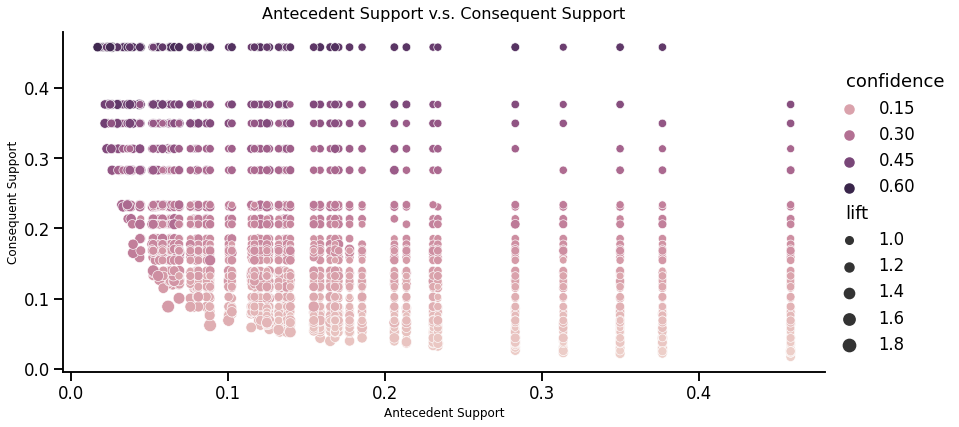

In [19]:
# take a quick look at the distribution of the product combination
sns.set_context("talk")
sns.relplot(x='antecedent support', y='consequent support', data=rules, 
            size='lift', hue='confidence', height=6, aspect=2)
plt.title("Antecedent Support v.s. Consequent Support", fontsize=16, y=1.02)
plt.xlabel('Antecedent Support', fontsize=12)
plt.ylabel('Consequent Support', fontsize=12)
plt.show()

# 4. Analyze
## 4.1 Dataset-1 (Customer IDs, Transaction dates, and Items)
So far, the datafame is ready for a further analysis.

In [20]:
# regarding the whole mike has the highest support, choose it as the item for the basket analysis
rules_sel = rules[rules["antecedents"].apply(lambda x: "whole milk" in x)]
rules_sel.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
1869,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564,0.181562
2048,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592,0.189591
2187,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310,0.091184
2251,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640
2227,(whole milk),(tropical fruit),0.458184,0.233710,0.116470,0.254199,1.087672,0.009388,1.027473,0.148768
...,...,...,...,...,...,...,...,...,...,...
1313,(whole milk),(frozen dessert),0.458184,0.023089,0.012057,0.026316,1.139766,0.001479,1.003314,0.226326
749,(whole milk),(canned vegetables),0.458184,0.020523,0.011544,0.025196,1.227674,0.002141,1.004793,0.342277
2087,(whole milk),(salt),0.458184,0.022832,0.011288,0.024636,1.079004,0.000826,1.001849,0.135137
1179,(whole milk),(dog food),0.458184,0.017188,0.010005,0.021837,1.270428,0.002130,1.004752,0.392871


In [21]:
# get the most important 5 items that customers would buy after purchasing whole milk 
rules_support = rules_sel['support'] >= rules_sel['support'].quantile(q = 0.95)
rules_confi = rules_sel['confidence'] >= rules_sel['confidence'].quantile(q = 0.95)
rules_lift = rules_sel['lift'] > 1
rules_zhang = rules_sel['zhang'] > 0
rules_best = rules_sel[rules_support & rules_confi & rules_lift & rules_zhang]
rules_best

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
1869,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564,0.181562
2048,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592,0.189591
2187,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310,0.091184
2227,(whole milk),(tropical fruit),0.458184,0.233710,0.116470,0.254199,1.087672,0.009388,1.027473,0.148768
2251,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640


In [22]:
# prepare the top 10 persentile items for visualization
rules_eda = rules.copy(deep=True)
rules_support_eda = rules_eda['support'] >= rules_eda['support'].quantile(q = 0.9)
rules_confi_eda = rules_eda['confidence'] >= rules_eda['confidence'].quantile(q = 0.9)
rules_lift_eda = rules_eda['lift'] > 1
rules_zhang_eda = rules_eda['zhang'] > 0
rules_best_eda = rules_eda[rules_support_eda & rules_confi_eda & rules_lift_eda & rules_zhang_eda]
rules_best_eda.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
111,(beef),(other vegetables),0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966,0.129082
137,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919,0.165762
298,(bottled beer),(other vegetables),0.158799,0.376603,0.068497,0.431341,1.145345,0.008692,1.096257,0.150857
306,(bottled beer),(rolls/buns),0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240,0.142829
330,(bottled beer),(whole milk),0.158799,0.458184,0.085428,0.537964,1.174124,0.012669,1.172672,0.176297


In [23]:
# remove the parentheses in the antecedents and consequents columns
rules_best_eda['antecedents'] = rules_best_eda['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda['consequents'] = rules_best_eda['consequents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
111,beef,other vegetables,0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966,0.129082
137,beef,whole milk,0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919,0.165762
298,bottled beer,other vegetables,0.158799,0.376603,0.068497,0.431341,1.145345,0.008692,1.096257,0.150857
306,bottled beer,rolls/buns,0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240,0.142829
330,bottled beer,whole milk,0.158799,0.458184,0.085428,0.537964,1.174124,0.012669,1.172672,0.176297


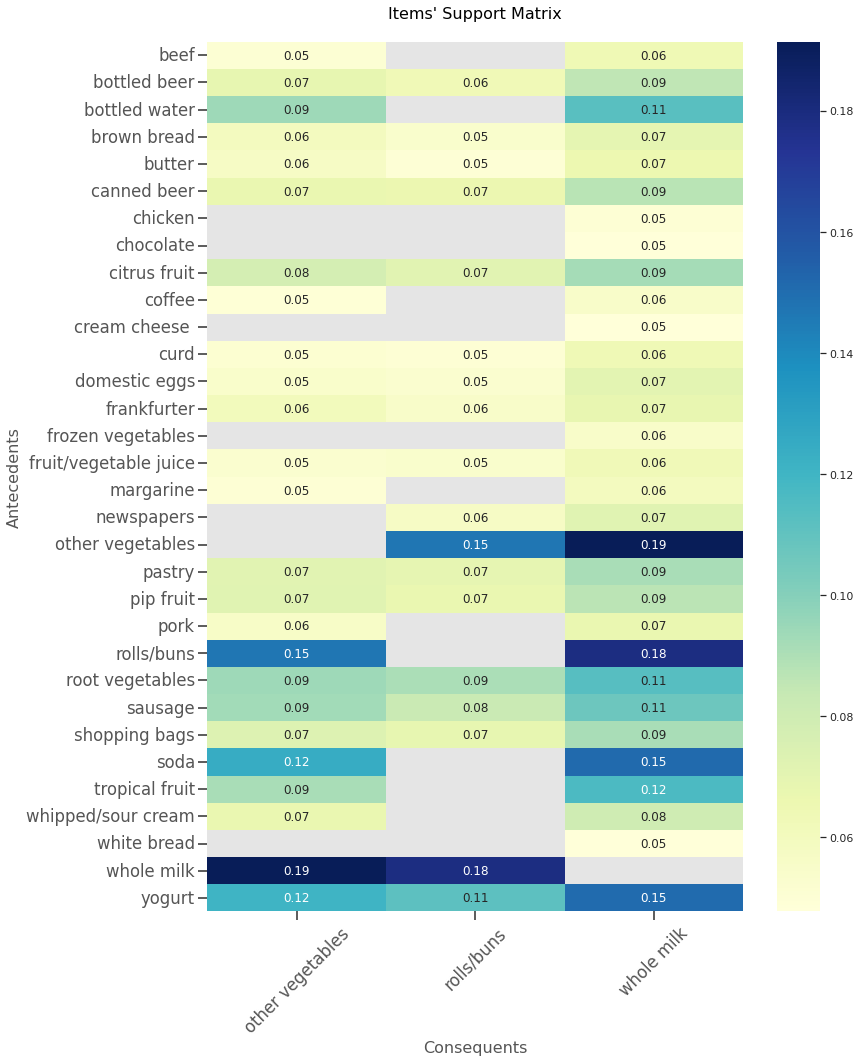

In [24]:
# plot a heatmap to know how strong the association is based on lift values
pivot_support = rules_best_eda.pivot(index='antecedents', columns='consequents', values='support')

sns.set_context("talk")
plt.style.use('ggplot')
plt.subplots(figsize=(12, 16))
sns.set()
ax = sns.heatmap(data=pivot_support, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title("Items' Support Matrix", fontsize=16, y=1.02)
ax.set_xlabel("Consequents",fontsize=16)
ax.set_ylabel("Antecedents",fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show() 

In [25]:
# plot a heatmap to know how strong the association is regarding lift values
pivot_confidence = rules_best_eda.pivot(index='antecedents', columns='consequents', values='confidence')

fig = ff.create_annotated_heatmap(pivot_confidence.to_numpy().round(2), 
                                  x=list(pivot_confidence.columns), 
                                  y=list(pivot_confidence.index), 
                                  colorscale=['grey', 'orange', 'red'], 
                                  font_colors=['white', 'white', 'white'])
fig.update_layout(
    template='simple_white',
    autosize=False,
    width=800,
    height=800,
    title="Lift Matrix",
    xaxis_title='Consequents',
    yaxis_title='Antecedents',
    legend_title="Legend Title",
    font=dict(
        family="Caliber",
        size=14,
        color="Black"
    )
)
fig.update_layout(title_x=0.22, title_y=0.98)
fig.update_traces(showscale=True)
fig.show()

In [26]:
# plot the network to see the connections between the top 10 percentile items
network_A = list(rules_best_eda["antecedents"].unique())
network_B = list(rules_best_eda["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules_best_eda.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Connection of Top 10 Percentile Items',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

In [27]:
#Scatter plot to see where the best consequents of whole milk are
rules_fix = rules.copy(deep=True)
rules_fix['antecedents'] = rules_fix['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_fix['consequents'] = rules_fix['consequents'].apply(lambda a: ', '.join(list(a)))

fig=go.Figure()
fig.add_trace(
    go.Scatter(x=rules_fix['support'], y=rules_fix['zhang'], name='All Combinations', mode='markers', opacity=0.3)
)
fig.add_trace(
    go.Scatter(x=rules_best['support'], y=rules_best['zhang'], name='Top 5 Consequents', mode='markers')
)

annotaion_01={'x':'0.191380', 'y':'0.181562', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Other Vegetables', 'textangle':-90, 'font':{'size':12, 'color':'green'}}
annotaion_02={'x':'0.178553', 'y':'0.189591', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Rolls/buns', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_03={'x':'0.151103', 'y':'0.091184', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Soda', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_04={'x':'0.116470', 'y':'0.148768', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Tropical Fruit', 'textangle':-90,'font':{'size':12, 'color':'green'}}
annotaion_05={'x':'0.150590', 'y':'0.256640', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'Yogurt', 'textangle':-90,'font':{'size':12, 'color':'green'}}

fig.update_layout({ 
    'annotations':[annotaion_01, annotaion_02, annotaion_03,
      annotaion_04, annotaion_05], 
      'showlegend':True, 'legend':{'x':0.76, 'y':0.04, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Support",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Confidence",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_layout(title='Contribution of The Top Items', title_x=0.5, title_y=0.86)
fig.show()


In [28]:
# the comparison between the sopport and confidence of all combinations
fig = px.scatter(rules_fix, x='support', y='confidence', 
                 color='lift', hover_data=['antecedents', 'confidence'],
                 labels={
                     "support": "Support",
                     "confidence": "Confidence",
                     'lift': 'Lift'
                 },
                title="Support v.s. Confidence")
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

In [29]:
# plot a network to show the connections of all combinations
network_A = list(rules_fix["antecedents"].unique())
network_B = list(rules_fix["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules_fix.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='electric',
        reversescale=False,
        color=[],
        size=8,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='All Item Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

## 4.2 Dataset-2 (Transaction with Items Only)
First, review the total number of items to see wether there is any difference between dataset 1 and dataset 2. After checking, the numbers are the same. However, this analysis will generate a dataframe based on every transaction instead of customer IDs.

In [30]:
# review the numbers of all items
freq_bk = bk.apply(pd.value_counts).transpose().sum().sort_values(ascending=False)
freq_bk.head(10)

whole milk          2502.0
other vegetables    1898.0
rolls/buns          1716.0
soda                1514.0
yogurt              1334.0
root vegetables     1071.0
tropical fruit      1032.0
bottled water        933.0
sausage              924.0
citrus fruit         812.0
dtype: float64

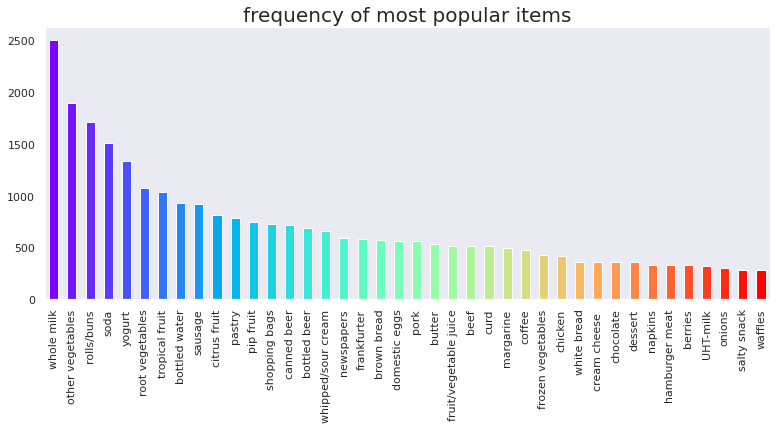

In [31]:
# Again, plot a bar chart to review the top 40 items being sold
color = plt.cm.rainbow(np.linspace(0, 1, 40))
freq_bk.head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [32]:
# fill na as 'NA' to tranform every value into string 
bk.fillna('NA',inplace=True)
bk_2d = bk.values.tolist()
bk_2d[0]

['whole milk',
 'pastry',
 'salty snack',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA',
 'NA']

In [33]:
# iterate every value which is not 'NA'
for i in range(len(bk_2d)):
    bk_2d[i] = [x for x in bk_2d[i] if not x=='NA']
bk_2d[0:5]

[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles']]

In [34]:
# create a item matrix
TE = TransactionEncoder()
TE.fit(bk_2d)
item_matrix = TE.transform(bk_2d)
bk_item = pd.DataFrame(item_matrix, columns = TE.columns_)
print(bk_item.shape)
bk_item.head()

(14963, 167)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
# get the support values by Apriori
bk_freq_items = apriori(bk_item, min_support=0.01, use_colnames=True, max_len=2)
bk_freq_items.sort_values(by = "support", ascending = False)

,support,itemsets
62,0.157923,(whole milk)
40,0.122101,(other vegetables)
46,0.110005,(rolls/buns)
52,0.097106,(soda)
63,0.085879,(yogurt)
...,...,...
64,0.010559,"(other vegetables, rolls/buns)"
29,0.010559,(herbs)
45,0.010493,(red/blush wine)
44,0.010158,(processed cheese)


In [36]:
# get a dataframe with support, confidence, and lift values by Association Rules 
bk_rules = association_rules(bk_freq_items, metric = "confidence", min_threshold = 0)
bk_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(rolls/buns),0.122101,0.110005,0.010559,0.086481,0.786154,-0.002872,0.974249
1,(rolls/buns),(other vegetables),0.110005,0.122101,0.010559,0.095990,0.786154,-0.002872,0.971117
2,(other vegetables),(whole milk),0.122101,0.157923,0.014837,0.121511,0.769430,-0.004446,0.958551
3,(whole milk),(other vegetables),0.157923,0.122101,0.014837,0.093948,0.769430,-0.004446,0.968928
4,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350
5,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550
6,(soda),(whole milk),0.097106,0.157923,0.011629,0.119752,0.758296,-0.003707,0.956636
7,(whole milk),(soda),0.157923,0.097106,0.011629,0.073635,0.758296,-0.003707,0.974663
8,(yogurt),(whole milk),0.085879,0.157923,0.011161,0.129961,0.822940,-0.002401,0.967861
9,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638


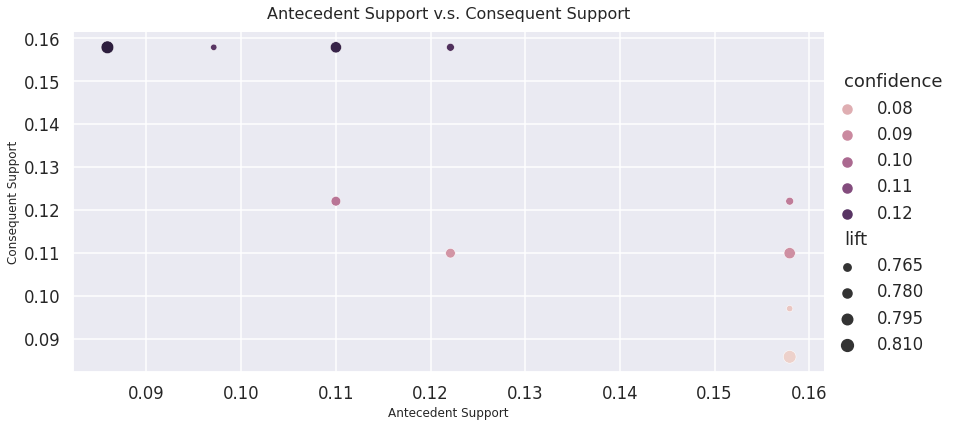

In [37]:
# only 10 combinations when preparing it based on each transaction
sns.set_context("talk")
sns.relplot(x='antecedent support', y='consequent support', data=bk_rules, 
            size='lift', hue='confidence', height=6, aspect=2)
plt.title("Antecedent Support v.s. Consequent Support", fontsize=16, y=1.02)
plt.xlabel('Antecedent Support', fontsize=12)
plt.ylabel('Consequent Support', fontsize=12)
plt.show()

In [38]:
# Add Zhang's values to complete the dataframe
bk_rules_zhangs_list = zhangs_rule(bk_rules)
bk_rules = bk_rules.assign(zhang = bk_rules_zhangs_list)
bk_rules['antecedents'] = bk_rules['antecedents'].apply(lambda a: ', '.join(list(a)))
bk_rules['consequents'] = bk_rules['consequents'].apply(lambda a: ', '.join(list(a)))
bk_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
0,other vegetables,rolls/buns,0.122101,0.110005,0.010559,0.086481,0.786154,-0.002872,0.974249,-0.236553
1,rolls/buns,other vegetables,0.110005,0.122101,0.010559,0.095990,0.786154,-0.002872,0.971117,-0.234091
2,other vegetables,whole milk,0.122101,0.157923,0.014837,0.121511,0.769430,-0.004446,0.958551,-0.254477
3,whole milk,other vegetables,0.157923,0.122101,0.014837,0.093948,0.769430,-0.004446,0.968928,-0.262461
4,whole milk,rolls/buns,0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350,-0.224474


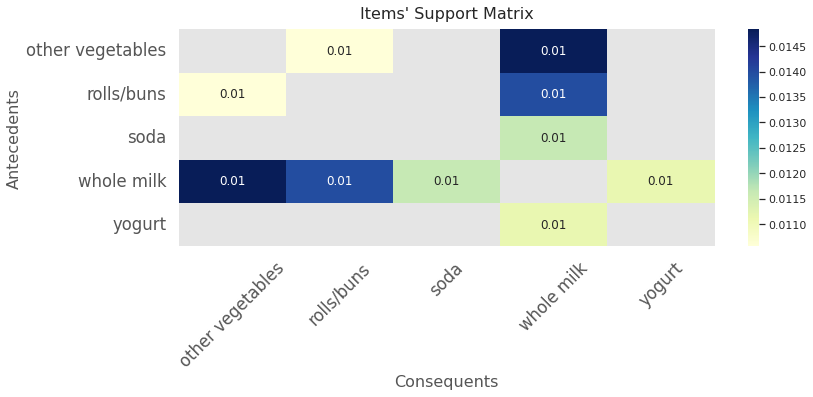

In [39]:
# plot a heatmap to know how strong the association is based on lift values
bk_pivot_suport = bk_rules.pivot(index='antecedents', columns='consequents', values='support')

sns.set_context("talk")
plt.style.use('ggplot')
plt.subplots(figsize=(12, 4))
sns.set()
ax = sns.heatmap(data=bk_pivot_suport, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title("Items' Support Matrix", fontsize=16, y=1.02)
ax.set_xlabel("Consequents",fontsize=16)
ax.set_ylabel("Antecedents",fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show() 


In [40]:
# review the heatmap see whether whole milk is also the item with the highest confidence
bk_pivot_confi = bk_rules.pivot(index = 'antecedents', columns = 'consequents', values= 'confidence')

fig = go.Figure(data=go.Heatmap(x=bk_pivot_confi.columns, y=bk_pivot_confi.index, z=bk_pivot_confi, 
                                colorscale='ylgnbu', reversescale=False))
fig.update_layout(
    template='ggplot2',
    autosize=False,
    width=800,
    height=400,
    title="Confidence Matrix",
    xaxis_title='Consequents',
    yaxis_title='Antecedents',
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="Black"
    )
)
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()


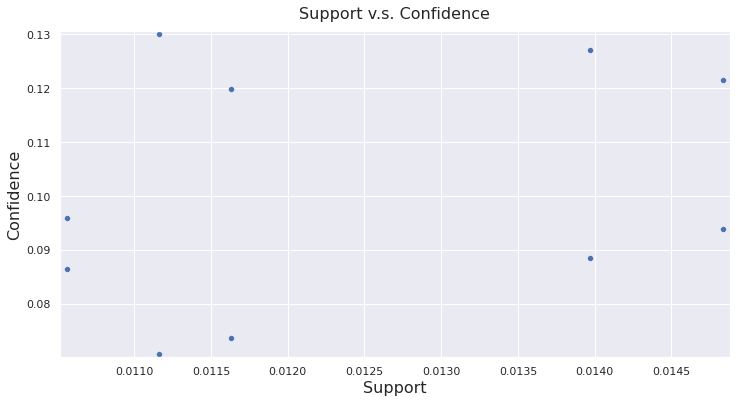

In [41]:
# See the distribution of these 10 combinations
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x = "support", y = "confidence", data = bk_rules, alpha=1)
plt.title("Support v.s. Confidence", fontsize=16, y=1.02)
ax.set_xlabel("Support",fontsize=16)
ax.set_ylabel("Confidence",fontsize=16)
plt.margins(0.01,0.01)
plt.show()

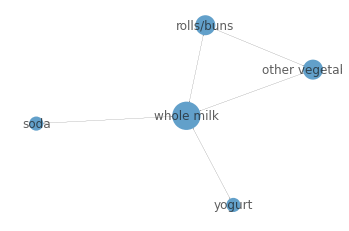

In [42]:
bk_network = bk_rules[['antecedents', 'consequents']]

bk_network_G = nx.from_pandas_edgelist(
    bk_network,
    source = 'antecedents',
    target = 'consequents',
    create_using = nx.DiGraph())

network_bt = nx.in_degree_centrality(bk_network_G)
bk_network_bt = pd.DataFrame(list(network_bt.items()), columns = ['item', 'centrality'])
bk_network_bt = bk_network_bt.dropna(axis=0)

pos = nx.kamada_kawai_layout(bk_network_G)

sizes = [x[1]*100 for x in bk_network_G.degree()]

nx.draw_networkx(bk_network_G, pos, 
    with_labels = True, 
    node_size = sizes,
    width = 0.1, alpha = 0.7,
    arrowsize = 2, linewidths = 0)

plt.axis('off')
plt.show()

# 5. Conclusion
In sum, here are viewpoints as below.

1. Top 10 sold items are whole milk, other vegetables, rolls/buns, soda, yogurt, root vegetables, tropical fruit, bottled water, sausage, and citrus fruit.

2. Top 5 consequents of whole milk are other vegetables, rolls/buns, soda, tropical fruit, and yogurt.

3. Every item in the top 10 percentile of all combinations has high confidence that customers buy the items with the whole wilk.

4. Regarding the network graphics, whole milk has the highest number of connections with other items.

5. Total items in these two datasets are the same. However, if generating a basket analysis dataframe based on each transaction, the number of combinations would be fewer than creating it based on customer IDs.

Suggested further analysis.

1. Since there is a dataset with transaction dates and customer IDs, the dataset can also proceed with a sales trend or customer behavior analysis.

2. Choose other items to explore what consequents should be prepared in order to prevent product insufficiency.

3. Other visual types to explore more insights.